In [1]:
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
import requests

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

from scipy.stats import norm

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.debugger import set_trace
#from statsmodels.stats.proportion import proportion_ztest

# Step 1: Acquire Data From CSV File

In [2]:
beach_complete = pd.read_csv('beach_complete.csv',delimiter=',',header=0,index_col=0)

In [3]:
beach_complete.head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9
sampleDate,,,,,,,,,,,
2009-06-01,27.0,12.0,39.0,28.0,11.0,18.0,24.0,63.0,51.0,10.0,10.0
2009-06-02,10.0,14.0,52.0,16.0,10.0,18.0,22.0,18.0,19.0,10.0,10.0
2009-06-03,22.0,11.0,14.0,10.0,10.0,11.0,14.0,10.0,10.0,10.0,10.0
2009-06-04,26.0,10.0,11.0,10.0,10.0,11.0,11.0,10.0,10.0,10.0,10.0
2009-06-05,35.0,10.0,31.0,11.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0
2009-06-06,133.0,13.0,29.0,18.0,12.0,10.0,12.0,16.0,10.0,12.0,10.0
2009-06-07,604.0,16.0,20.0,97.0,37.0,28.0,41.0,47.0,10.0,12.0,11.0
2009-06-08,405.0,17.0,99.0,142.0,31.0,33.0,43.0,39.0,10.0,10.0,12.0
2009-06-09,NaN,37.0,368.0,63.0,11.0,20.0,16.0,11.0,12.0,18.0,34.0


In [4]:
beach_clean = beach_complete.dropna()

In [5]:
beach_clean.apply(pd.to_numeric);

In [6]:
#fig, ax = plt.subplots(6, 2, figsize=(20,40))
#cols = beach_clean.columns
#for i in range(6):
#    for j in range(2):
#        if j == 1 and i == 5:
#            break
#        elif j == 0:
#            ax[i][j].hist(np.log(beach_clean[cols[i]].values), bins=50, histtype='stepfilled')
#            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i])
            #set_trace()
#        else:
#            ax[i][j].hist(np.log(beach_clean[cols[i+6]]).values, bins=50, histtype='stepfilled')
#            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i+6])

In [70]:
sunnyside = beach_clean['Sunnyside-2']

In [71]:
sunnyside.size

668

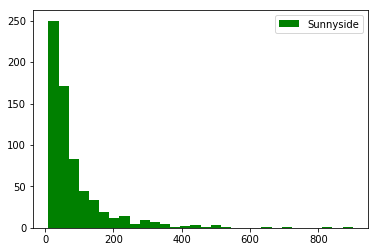

In [72]:
plt.hist(sunnyside, bins=30, histtype='bar', color='green', label = 'Sunnyside')
plt.legend()
plt.show();

In [73]:
#Turn sunnyside into a separate dataframe with time values
# sunnyside_frame = sunnyside.to_frame(name='value')
# sunnyside_frame.head()

In [74]:
#Create pivot table
# sunnyside_pivot = sunnyside_frame.pivot_table(values='value', aggfunc='mean', 
#                                               index=sunnyside_frame.index.day, 
#                                               columns=sunnyside_frame.index.year)

In [75]:
#sunnyside_pivot.dropna()

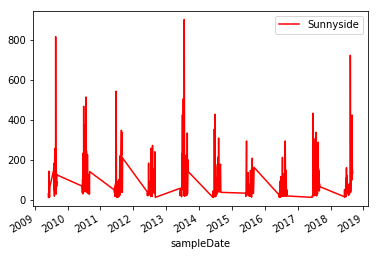

In [76]:
sunnyside.plot(color='red', label = 'Sunnyside')
plt.legend()
plt.show();

# Step 2: ACF and PACF plots

In [77]:
#def plot_acf_pacf(list_tuples):
#    fig, ax = plt.subplots(11, 2, figsize=(20,40))
#    for i in range(len(list_tuples)):
#        for j in range(len(list_tuples[i])-1):
#            str_title_acf = "Autocorrelation " + list_tuples[i][1]
#            str_title_pacf = "Partial Autocorrelation  " + list_tuples[i][1]
#            plot_acf(list_tuples[i][0], lags=50, title=str_title_acf, ax=ax[i][j])
#            plot_pacf(list_tuples[i][0], lags=50, title=str_title_pacf, ax=ax[i][j+1])
    
#    plt.show();

#plot_acf_pacf(list_tuples)

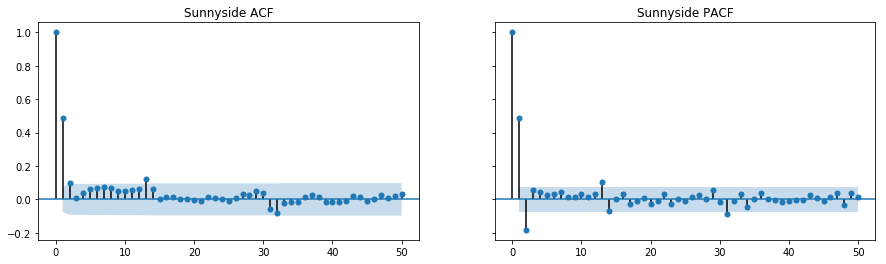

In [78]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,4))
plot_acf(sunnyside, lags=50, title='Sunnyside ACF', ax=ax[0])
plot_pacf(sunnyside, lags=50, title='Sunnyside PACF', ax=ax[1])
plt.show();

For all 11 beaches, it seems that with a lag=6 there will be very little partial correlation. So we assume lag=6 for both our AR and MA parameters for now.

# Step 5: Train and Test ARIMA model 

In [13]:
train_size = int(0.7 * sunnyside.size)
test_size = int(0.3 * sunnyside.size)
train = sunnyside[:train_size]
test = sunnyside[train_size:train_size+test_size+1]

In [14]:
train.head()

sampleDate
2009-06-01    28.0
2009-06-02    16.0
2009-06-03    10.0
2009-06-04    10.0
2009-06-05    11.0
Name: Sunnyside-2, dtype: float64

In [15]:
test.head()

sampleDate
2016-06-10    11.0
2016-06-11    13.0
2016-06-12    34.0
2016-06-13    29.0
2016-06-14    12.0
Name: Sunnyside-2, dtype: float64

In [16]:
train.size

467

In [17]:
test.size

201

In [18]:
model = ARIMA(endog=train.values, order=(5,1,5))

In [19]:
fit = model.fit(disp=0)

In [20]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  466
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -2747.262
Method:                       css-mle   S.D. of innovations             87.072
Date:                Fri, 26 Apr 2019   AIC                           5518.525
Time:                        20:36:09   BIC                           5568.255
Sample:                             1   HQIC                          5538.097
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0403      0.060     -0.669      0.504      -0.158       0.078
ar.L1.D.y      0.1698      0.279      0.608      0.544      -0.378       0.717
ar.L2.D.y     -0.0860      0.156     -0.551      0.582      -0.392       0.220
ar.L3.D.y      0.7883      0.097      8.101      0.000       0.598       0.979
ar.L4.D.y     -0.3058      0.231     -1.322      0.187      -0.759       0.148
ar.L5.D.y      0.1632      0.118      1.386      0.167      -0.068       0.394
ma.L1.D.y     -0.6199      0.285     -2.179      0.030      -1.178      -0.062
ma.L2.D.y     -0.2951      0.247     -1.194      0.233      -0.779       0.189
ma.L3.D.y     -0.9173      0.068    -13.555      0.000      -1.050      -0.785
ma.L4.D.y      0.7530      0.255      2.952      0.003       0.253       1.253
ma.L5.D.y      0.0792      0.275      0.288      0.773      -0.459       0.617
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5805           -0.8513j            1.0304           -0.3453
AR.2           -0.5805           +0.8513j            1.0304            0.3453
AR.3            1.1215           -0.0000j            1.1215           -0.0000
AR.4            0.9567           -2.0571j            2.2687           -0.1807
AR.5            0.9567           +2.0571j            2.2687            0.1807
MA.1           -0.5620           -0.8274j            1.0002           -0.3450
MA.2           -0.5620           +0.8274j            1.0002            0.3450
MA.3            1.0000           -0.0000j            1.0000           -0.0000
MA.4            1.1933           -0.0000j            1.1933           -0.0000
MA.5          -10.5758           -0.0000j           10.5758           -0.5000
-----------------------------------------------------------------------------
"""

# Step 6: ARIMA Model Test Results 

In [88]:
hist = list(train.values)
pred = []

for i in range(test.size):
    model_fit = ARIMA(endog=hist, order=(0,1,3)).fit()
    pred.append(model_fit.forecast()[0][0])
    hist.append(test.values[i])

/home/rkumar/anaconda3/envs/DS1ENV/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


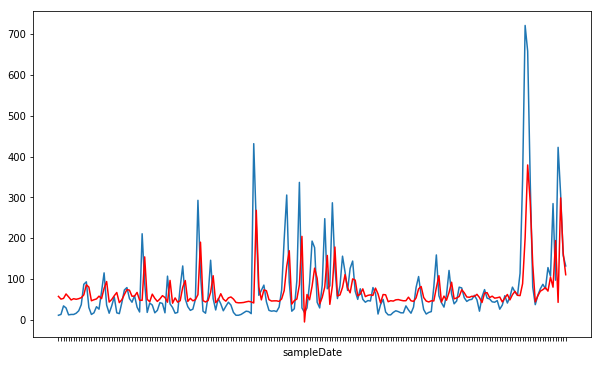

In [90]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
test.plot()
ax.plot(test.index, pred, 'r-')
plt.show();

The RMSE values closer to 0 indicates better fit. 

From above RMSE values, it is clear that ARIMA predictions were better for following beaches: Gibraltar, Centre, and Cherry. 

For Sunnyside, MCurtis and Kewbalmy, the ARIMA predictions are not reliable and hence other models should be used for better predictions. 

ARIMA did not perform so well for beaches Wards, Woodbine, and Rouge as well.

For all beaches, the ARIMA model with parameters (p,d,q) = (6,1,1) did not predict well on sudden spikes in e.Coli counts. This could possibly be because of the sudden changes that these spikes bring compared to the base values seen at the bottom of the above graphs. This will be explored in future with more fine-tuned ARIMA models. 